# Intraday Momentum

The genesis of this paper is from http://www.smallake.kr/wp-content/uploads/2015/01/SSRN-id2440866.pdf, which relates the first half hour of trading to the last half hour of trading. We will seek to replicate the results for the OIH Index (Market Vectors Oil Services ETF). 

In [1]:
# We hate warnings
import warnings
warnings.simplefilter('ignore')

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
import math
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm

In [2]:
# Our monkey patch for pyfolio :(
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def create_custom_tear_sheet(returns, positions=None,
                              transactions=None,
                              live_start_date=None,
                              cone_std=(1.0, 1.5, 2.0),
                              benchmark_rets=None,
                              bootstrap=False,
                              turnover_denom='AGB',
                              header_rows=None,
                              return_fig=False):
    """
    Generate a number of plots for analyzing a strategy's returns.
    - Fetches benchmarks, then creates the plots on a single figure.
    - Plots: rolling returns (with cone), rolling beta, rolling sharpe,
        rolling Fama-French risk factors, drawdowns, underwater plot, monthly
        and annual return plots, daily similarity plots,
        and return quantile box plot.
    - Will also print the start and end dates of the strategy,
        performance statistics, drawdown periods, and the return range.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - See full explanation in create_full_tear_sheet.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    benchmark_rets : pd.Series, optional
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    returns = returns[returns.index > benchmark_rets.index[0]]

    pf.show_perf_stats(returns, benchmark_rets)

    pf.show_worst_drawdown_periods(returns)

    # If the strategy's history is longer than the benchmark's, limit strategy
    if returns.index[0] < benchmark_rets.index[0]:
        returns = returns[returns.index > benchmark_rets.index[0]]

    vertical_sections = 12

    if live_start_date is not None:
        vertical_sections += 1
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    if bootstrap:
        vertical_sections += 1

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_rolling_returns = plt.subplot(gs[:2, :])

    i = 2
    ax_rolling_returns_vol_match = plt.subplot(gs[i, :],
                                               sharex=ax_rolling_returns)
    i += 1
    ax_rolling_returns_log = plt.subplot(gs[i, :],
                                         sharex=ax_rolling_returns)
    i += 1
    ax_returns = plt.subplot(gs[i, :],
                             sharex=ax_rolling_returns)
    i += 1
    ax_rolling_beta = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_volatility = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_sharpe = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_drawdown = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_underwater = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_monthly_heatmap = plt.subplot(gs[i, 0])
    ax_annual_returns = plt.subplot(gs[i, 1])
    ax_monthly_dist = plt.subplot(gs[i, 2])
    i += 1
    ax_return_quantiles = plt.subplot(gs[i, :])
    i += 1

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns)
    ax_rolling_returns.set_title(
        'Cumulative returns')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=None,
        volatility_match=True,
        legend_loc=None,
        ax=ax_rolling_returns_vol_match)
    ax_rolling_returns_vol_match.set_title(
        'Cumulative returns volatility matched to benchmark')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        logy=True,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns_log)
    ax_rolling_returns_log.set_title(
        'Cumulative returns on logarithmic scale')

    pf.plot_returns(
        returns,
        live_start_date=live_start_date,
        ax=ax_returns,
    )
    ax_returns.set_title(
        'Returns')

    pf.plot_rolling_beta(
        returns, benchmark_rets, ax=ax_rolling_beta)

    pf.plot_rolling_volatility(
        returns, factor_returns=benchmark_rets, ax=ax_rolling_volatility)

    pf.plot_rolling_sharpe(
        returns, ax=ax_rolling_sharpe)

    # Drawdowns
    pf.plot_drawdown_periods(
        returns, top=5, ax=ax_drawdown)

    pf.plot_drawdown_underwater(
        returns=returns, ax=ax_underwater)

    pf.plot_monthly_returns_heatmap(returns, ax=ax_monthly_heatmap)
    pf.plot_annual_returns(returns, ax=ax_annual_returns)
    pf.plot_monthly_returns_dist(returns, ax=ax_monthly_dist)

    pf.plot_return_quantiles(
        returns,
        live_start_date=live_start_date,
        ax=ax_return_quantiles)

    if bootstrap:
        ax_bootstrap = plt.subplot(gs[i, :])
        pf.plot_perf_stats(returns, benchmark_rets,
                                 ax=ax_bootstrap)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


First, I would like to investigate the average daily trading volume of each 30 minute interval to determine if the opening and closing hours are indeed more active than the rest of the day.

In [19]:
data = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\OIH\Volume.csv', index_col=0)
data.index = pd.to_datetime(data.index, format = '%d/%m/%Y %H:%M')

In [20]:
hour = [9, 10, 11, 12, 13, 14, 15]
min = [0, 30]
full_time = [(x, y) for x in hour for y in min][1:]

In [21]:
avg_vol = pd.Series()

for t in full_time:
     avg_vol[datetime.time(t[0], t[1])] = data['Volume'][data.index.time == datetime.time(t[0], t[1])].mean()

Text(0.5,1,'Average Traded Volume')

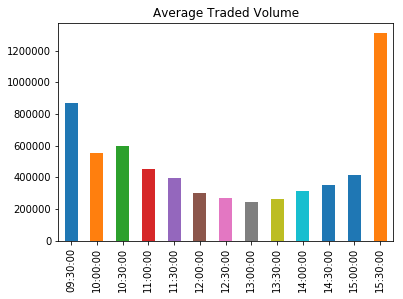

In [22]:
avg_vol.plot.bar()
plt.title('Average Traded Volume')

As expected, the opening half-hour (09:30) and the closing half-hour (15:30) are indeed more active than expected. Now, let's compute the overnight return (defined as previous close till 10am), the pre-close half hour returns (15:00 - 15:30) as well as the closing half-hour returns (15:30 - 16:00). Following which, we will run a simple multilinear regression, before attempting to contruct a trading strategy. 

In [23]:
# Read the open bid data 
trades_old = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\OIH\Trades.csv', 
                       index_col=0)
trades_old.index = pd.to_datetime(trades_old.index, format = '%d/%m/%Y %H:%M')

pre_open = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\OIH\Pre Open.csv', 
                       index_col=0)
pre_open.index = pd.to_datetime(pre_open.index, format = '%d/%m/%Y')

official_close = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\OIH\Official Close.csv', 
                       index_col=0)

official_close.index = pd.to_datetime(official_close.index, format = '%d/%m/%Y')
official_close = official_close['2018-02-26':]

In [24]:
# Create a formal standardized trading index based on official close dates
datetime_index = []

for date in official_close['2018-02-26':].index:
    # Shift the start time to 09:00
    start_time = date + pd.Timedelta(540, 'm')
    trading_period = list(pd.date_range(start_time, periods=436, freq='min', box=False))
    datetime_index += trading_period
    
trading_datetime_index = pd.DatetimeIndex(datetime_index)

In [25]:
# Configure the trade data to have the same datetime index 
trades = pd.DataFrame(index=trading_datetime_index)
trades['Open'] = trades_old['Open']
trades['Close'] = trades_old['Close']
trades.fillna(method='ffill', inplace=True)

In [26]:
# Set the closing hour
closing_time = datetime.time(15, 30)

close_1600 = trades['Close'][trades.index.time == datetime.time(15, 59)]
close_1600.index = close_1600.index.normalize()

open_1530 = trades['Open'][trades.index.time == datetime.time(15, 30)]
open_1530.index = open_1530.index.normalize()

open_1500 = trades['Open'][trades.index.time == datetime.time(15, 0)]
open_1500.index = open_1500.index.normalize()

close_ret = official_close['Official Close']/open_1530 - 1
pre_close_ret = open_1530/open_1500 - 1

In [27]:
# Set the opening hour
opening_time = datetime.time(9, 30)

# Read the close for the first half-hour open and normalize the data 
close_at_open = pd.DataFrame(trades['Close'][trades.index.time == datetime.time(9, 59)])
close_at_open.index = close_at_open.index.normalize()

close_at_close = pd.DataFrame(trades['Close'][trades.index.time == datetime.time(15, 59)])
close_at_close.index = close_at_close.index.normalize()
previous_close = close_at_close.shift(1).dropna()

open_ret = (close_at_open / previous_close - 1).dropna()

In [28]:
# Define my X and y
X = pd.DataFrame()
X['Overnight Ret'] = open_ret['Close']
X['Pre Close Ret'] = pre_close_ret[1:]
y = close_ret[1:]

In [66]:
# Define the variables for my OLS regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     14.56
Date:                Tue, 11 Sep 2018   Prob (F-statistic):           1.92e-06
Time:                        21:37:30   Log-Likelihood:                 621.08
No. Observations:                 135   AIC:                            -1238.
Df Residuals:                     133   BIC:                            -1232.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Overnight Ret    -0.0740      0.016     -4.658      0.000      -0.105      -0.043
Pre Close Ret     0.1396      0.075      1.870      0.064      -0.008       0.287
==============================================================================
Omnibus:                        1.048   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                0.630
Skew:                          -0.081   Prob(JB):                        0.730
Kurtosis:                       3.293   Cond. No.                         4.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The result of our multilinear regression turns out to be better than expected with an 18% predictive R-squared value. This is much higher than the 3% predictive R-squared value reported by the researchers for the SPY over their testing timeframe. 

However, one important thing to note is that the coefficient for our overnight return is actually negative. This is in stark contrast to the results published by the academics which reported a positive coefficient. (Perhaps the market has changed since then).

Since the sign of the overnight coefficient has changed from positive to negative, our strategy has changed from a intraday momentum strategy to a intraday mean reversion strategy. Nonetheless, let's define our new trading strategy. 

First of all, we want to investiage the effect of the overnight return. So for our strategy, we will go short (long) during the market closing half-hour when the overnight return is positive (negative). We shall add in a 4 basis point transaction costs for realistic backtesting purposes. 

## Overnight Return (15:00 - 10:00) and Closing Return (15:30 - 16:00)

In [46]:
df = pd.DataFrame(index=y.index)

# For our strategy, go opposite of the day open for the close, (include a 0.04% transaction cost)
df['Strat_Daily_rets'] = -np.sign(X['Overnight Ret']) * (y-0.0004)

# Our benchmark of always going long on the closing half-hour 
df['Benchmark_rets'] = y

# Calculate the cumulative returns of our strategy
df['Strat_perc_ret'] = (1 + df.Strat_Daily_rets).cumprod() - 1
df['Benchmark_perc_ret'] = (1 + df.Benchmark_rets).cumprod() - 1

Backtest months: 6


,Backtest
Annual return,24.4%
Cumulative returns,12.3%
Annual volatility,4.0%
Sharpe ratio,5.41
Calmar ratio,14.91
Stability,0.86
Max drawdown,-1.6%
Omega ratio,2.48
Sortino ratio,9.80
Skew,-0.19


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.63,2018-03-21,2018-03-27,2018-04-06,13
1,1.34,2018-06-07,2018-06-26,2018-07-30,38
2,0.52,2018-02-28,2018-03-01,2018-03-09,8
3,0.41,2018-03-12,2018-03-14,2018-03-16,5
4,0.37,2018-04-12,2018-04-17,2018-04-18,5


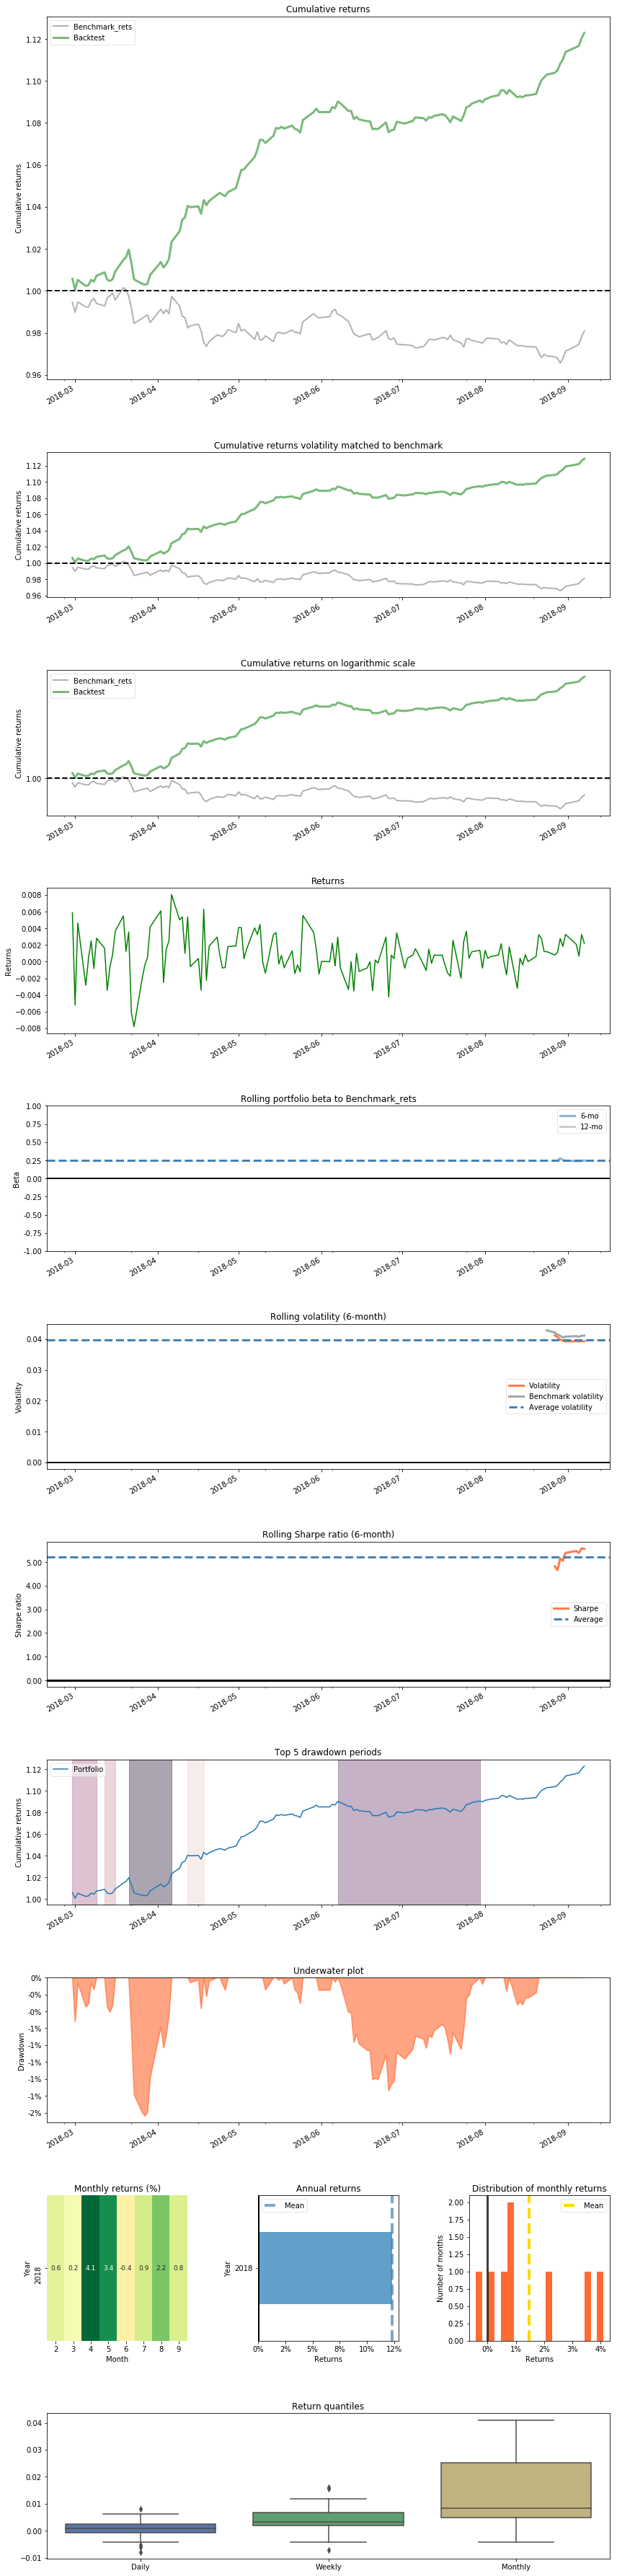

In [31]:
create_custom_tear_sheet(returns=df['Strat_Daily_rets'], benchmark_rets=df['Benchmark_rets'])

The strategy works really well! Though we can't really be sure, since we have only tested it out on 6 months worth of minute data.

### Adding the magnitude of overnight return as a filter

In [67]:
# Define the range for our overnight return
ret_range = list(zip(np.arange(0, 0.019, 0.001), np.arange(0.001, 0.020, 0.002)))

overall_results = pd.DataFrame()
ret_ranked = pd.Series()
ret_trades = pd.Series()

for i, j in ret_range:
     ret_ranked[i] = ((df['Strat_Daily_rets'])[(
         abs(X['Pre Close Ret']) >= i) & (abs(X['Pre Close Ret']) < j)]).mean()
        
for i, j in ret_range:
    ret_trades[i] =  ((df['Strat_Daily_rets'])[(
        abs(X['Pre Close Ret']) >= i) & (abs(X['Pre Close Ret']) < j)]).count()
    
overall_results['Overnight Ret'] = ret_ranked
overall_results['Trades'] = ret_trades

In [68]:
overall_results

,Overnight Ret,Trades
0.000,0.000931,39
0.001,0.000625,60
0.002,0.001388,53
0.003,0.001374,33
0.004,0.000646,17
0.005,0.000379,12
0.006,-0.000526,5
0.007,0.001110,3
0.008,-0.000440,1
0.009,-0.000440,1


Hmm, from our preliminary analysis, it seems like when the overnight return is small, the return of our strategy tends to be weak. Let's add in a simple filter by stating that we will only enter trades when the magnitude of the overnight return is greater than 0.1%.

Backtest months: 6


,Backtest
Annual return,29.3%
Cumulative returns,14.6%
Annual volatility,3.7%
Sharpe ratio,7.05
Calmar ratio,29.54
Stability,0.87
Max drawdown,-1.0%
Omega ratio,3.49
Sortino ratio,15.42
Skew,0.19


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.99,2018-06-07,2018-06-26,2018-07-25,35
1,0.82,2018-03-21,2018-03-26,2018-04-02,9
2,0.41,2018-03-12,2018-03-14,2018-03-16,5
3,0.32,2018-08-10,2018-08-15,2018-08-21,8
4,0.28,2018-03-02,2018-03-05,2018-03-07,4


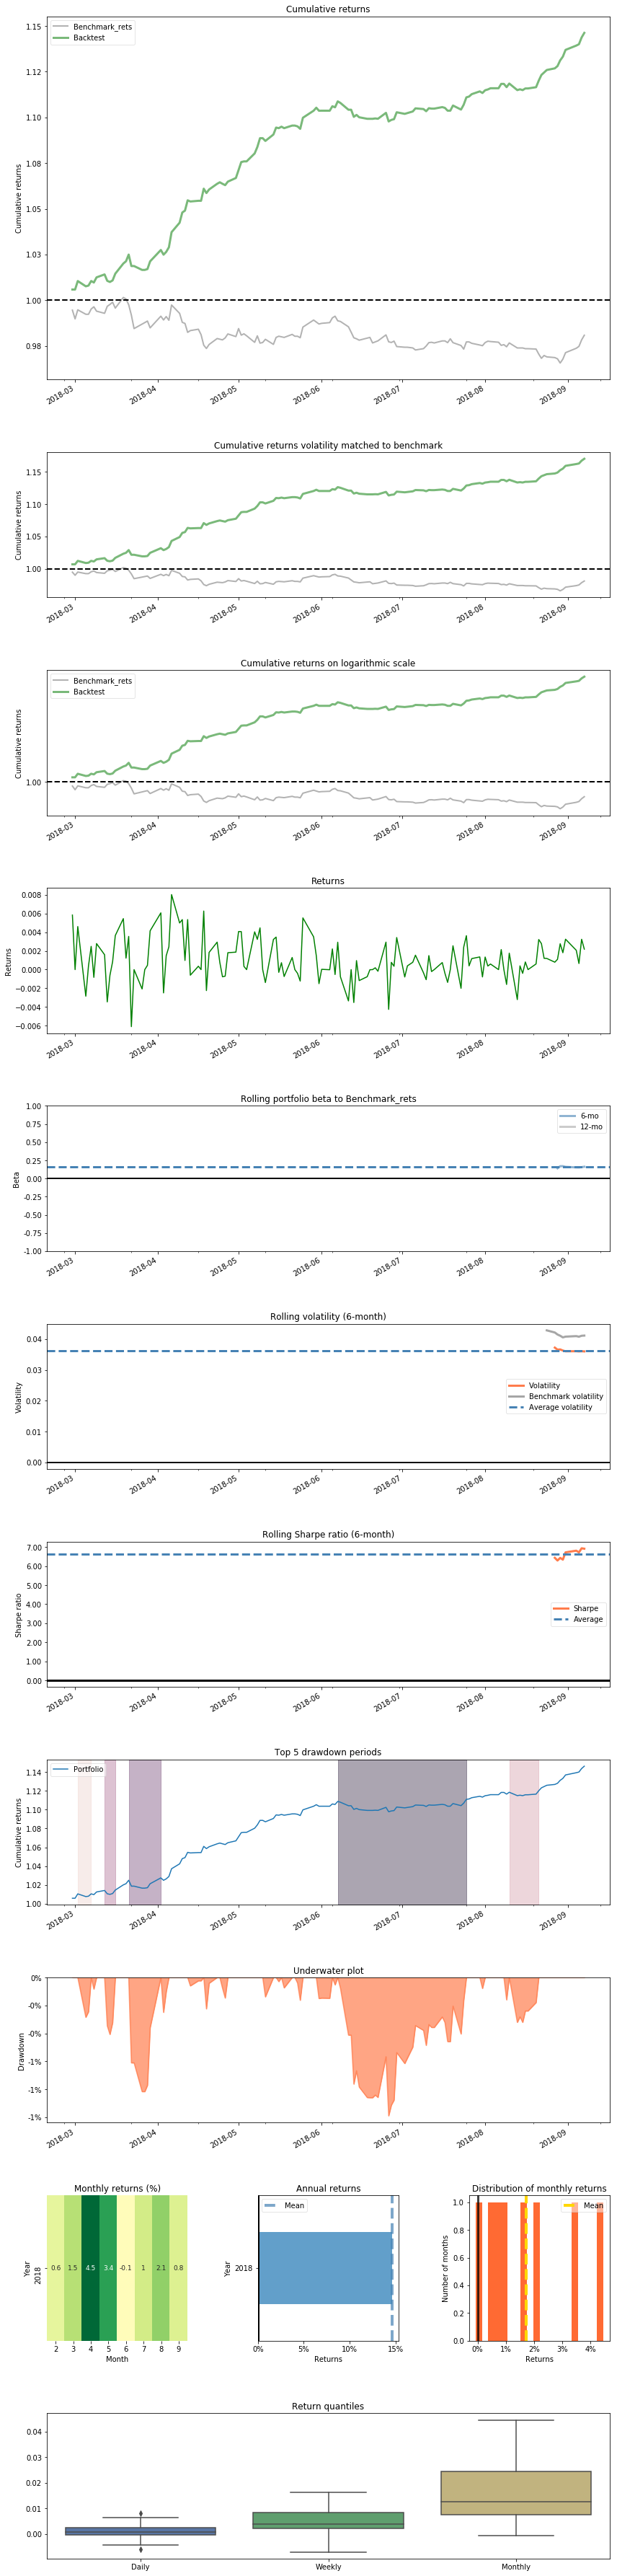

In [34]:
vol_adj_ret = df['Strat_Daily_rets'] * ((abs(X['Overnight Ret']) >=0.001))
create_custom_tear_sheet(returns=vol_adj_ret, benchmark_rets=df['Benchmark_rets'])

It seems like we get much better results and the filtered  strategy delivers a sharpe ratio of 7.05! However, there is a major drawback to our strategy, which is something that I will touch on later.

Now, let's calculate our percentage of winning trades!

In [35]:
wins = vol_adj_ret[vol_adj_ret>0].count()
losers = vol_adj_ret[vol_adj_ret<0].count()
wins/(wins+losers)

0.680327868852459

A 68% win rate, pretty decent for a strategy that has only 2 simple rules. 

Now, note that the coefficient for our pre-close return is still positive. Therefore, let's test it out using the pre-close returns (15:00 -15:30). Basically, the idea is similar. We will go long (short) for the closing half hour if the pre-close return is positive (negative).

Backtest months: 6


,Backtest
Annual return,11.0%
Cumulative returns,5.7%
Annual volatility,4.1%
Sharpe ratio,2.56
Calmar ratio,6.27
Stability,0.54
Max drawdown,-1.8%
Omega ratio,1.54
Sortino ratio,4.63
Skew,0.53


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.76,2018-05-30,2018-08-30,NaT,NaN
1,1.08,2018-03-09,2018-03-21,2018-03-23,11
2,0.84,2018-05-10,2018-05-18,2018-05-25,12
3,0.52,2018-02-28,2018-03-01,2018-03-05,4
4,0.50,2018-03-26,2018-03-29,2018-04-02,6


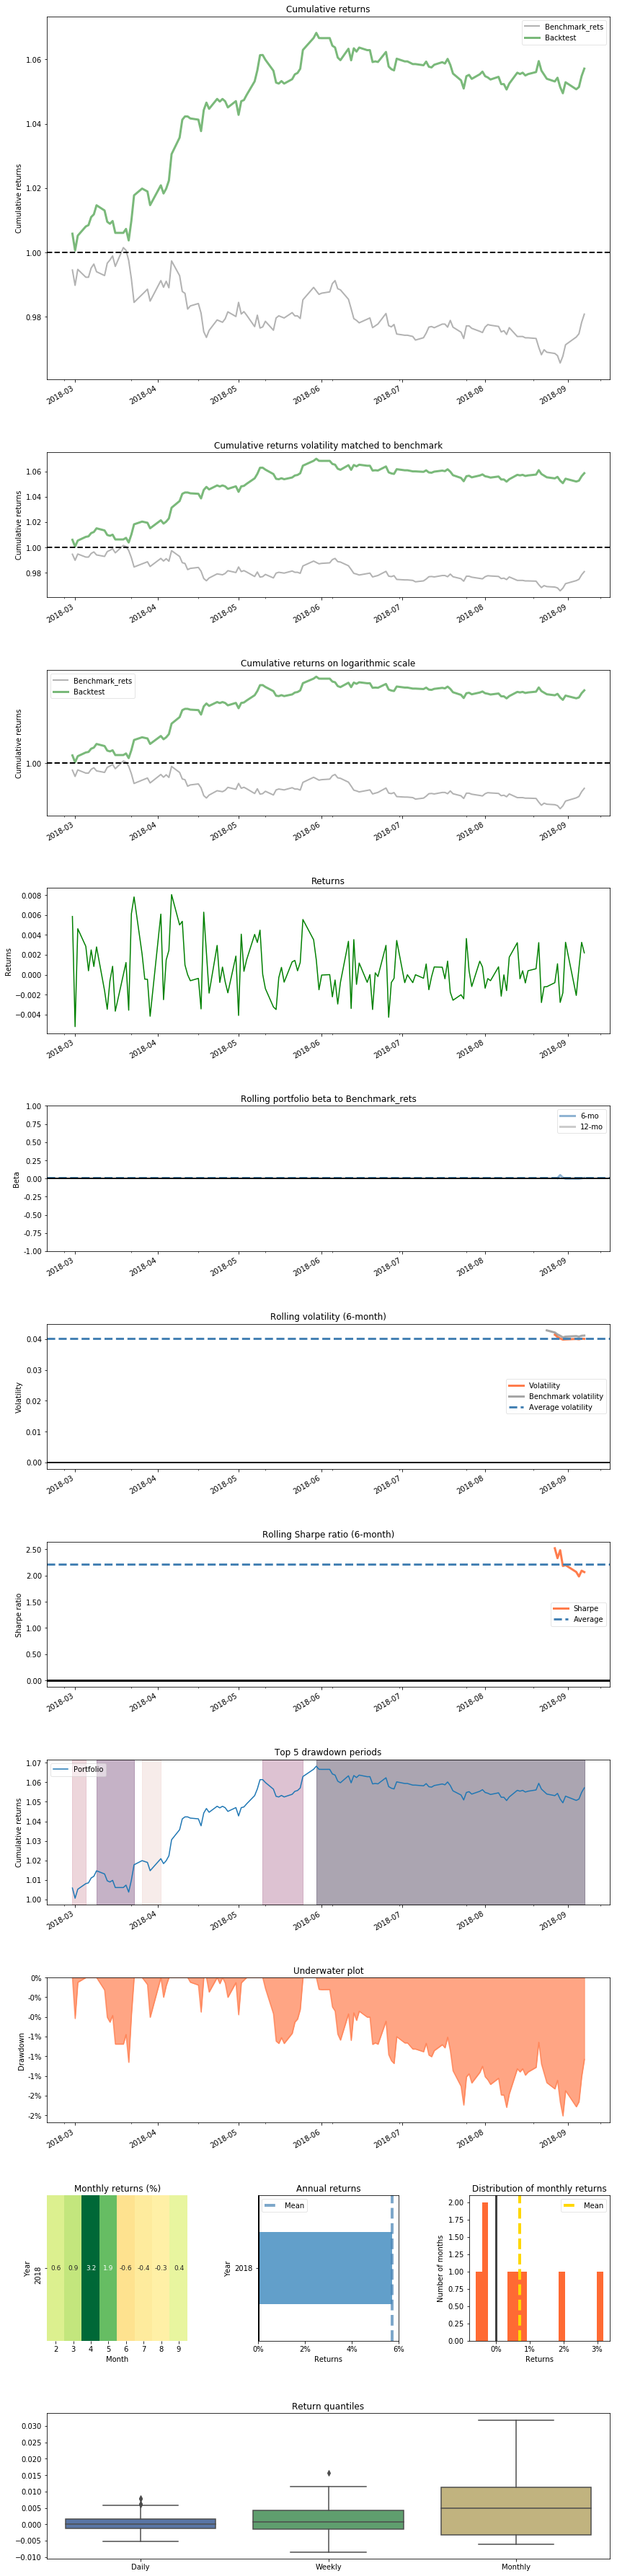

In [49]:
# The returns of our pre_close strategy with a 0.04% transaction cost
pre_close_ret = np.sign(X['Pre Close Ret']) * (y-0.0004)
create_custom_tear_sheet(returns=pre_close_ret, benchmark_rets=df['Benchmark_rets'])

Though the performance of this strategy is slightly weaker, it still performs pretty nicely. Let's see what happens when we combine both signals!

Backtest months: 6


,Backtest
Annual return,10.3%
Cumulative returns,5.4%
Annual volatility,3.1%
Sharpe ratio,3.18
Calmar ratio,7.17
Stability,0.62
Max drawdown,-1.4%
Omega ratio,2.08
Sortino ratio,6.29
Skew,0.86


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.44,2018-05-30,2018-07-23,2018-09-07,73
1,0.57,2018-03-12,2018-03-14,2018-04-02,16
2,0.52,2018-02-28,2018-03-01,2018-03-07,6
3,0.48,2018-04-12,2018-04-17,2018-04-18,5
4,0.41,2018-05-10,2018-05-18,2018-05-25,12


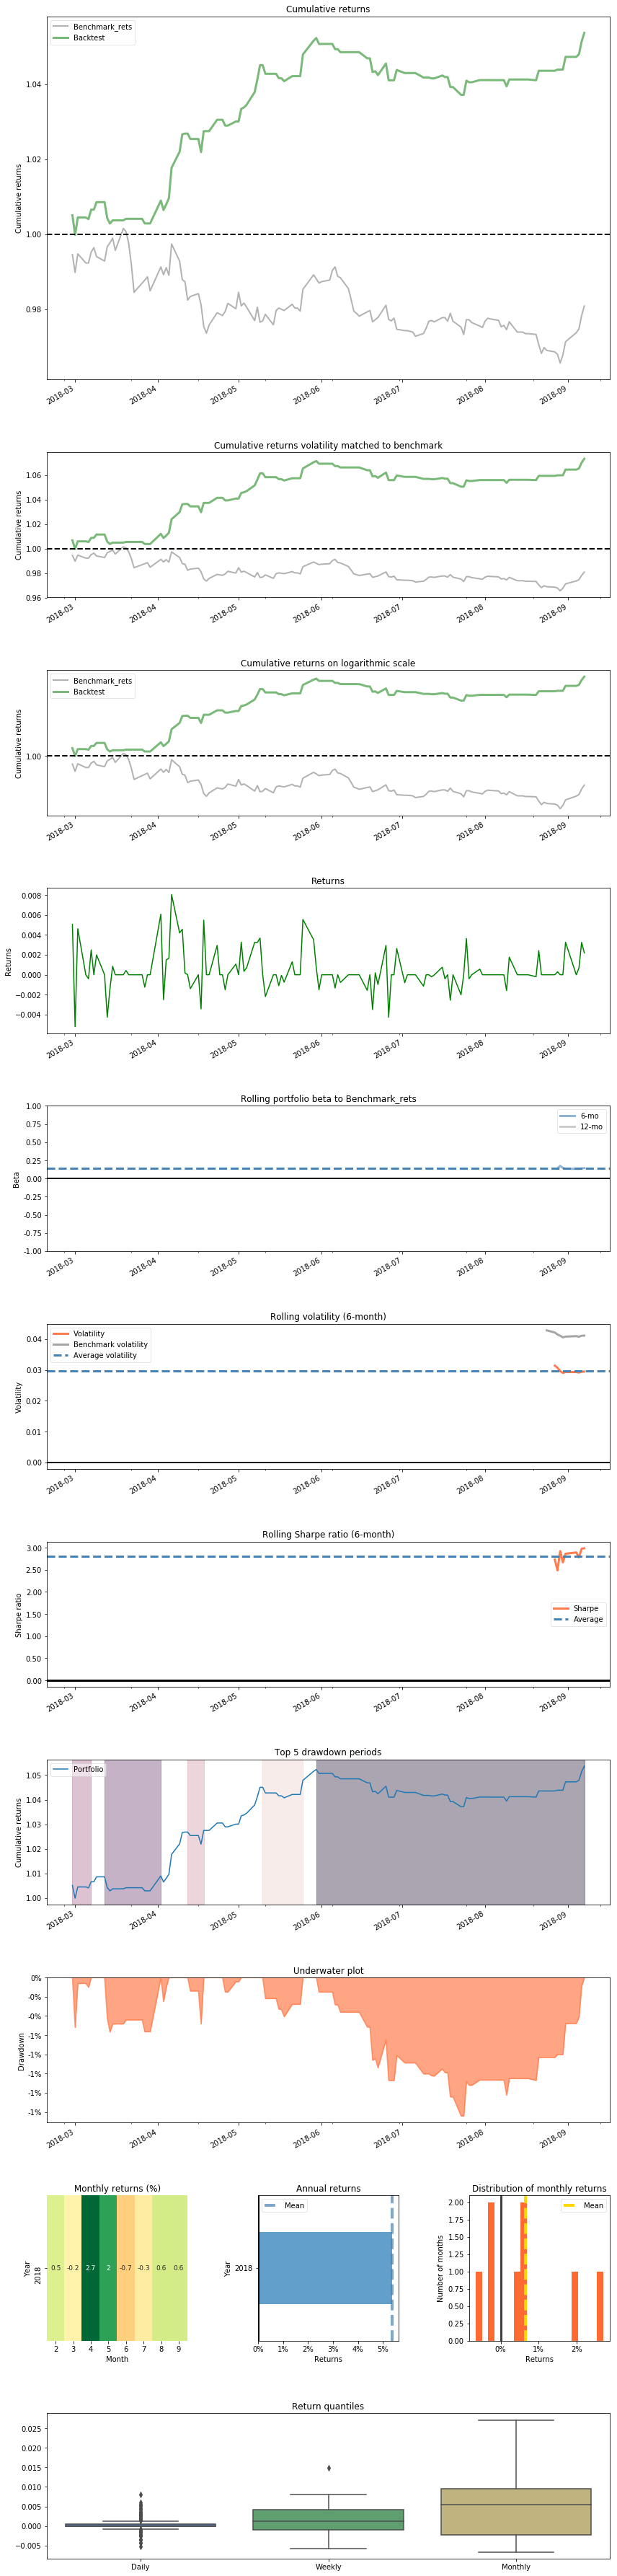

In [54]:
comb_ret = (((np.sign(X['Pre Close Ret'])>0) & (np.sign(X['Overnight Ret'])<0)) * (y-0.0004)) + (
((np.sign(X['Pre Close Ret'])<0) & (np.sign(X['Overnight Ret'])>0)) * (-y-0.0004))
create_custom_tear_sheet(returns=comb_ret, benchmark_rets=df['Benchmark_rets'])

This strategy is an improvement over simply using the pre-closing returns as a signal. However, it is still lacking compared to our first strategy, whereby we simply went the opposite of the overnight return. Perhaps we should test to see if the overnight returns and pre-close returns are correlated...

## Taking a twist

Based on my observation, momentum seems to last only early in the trading day. I.e. after a big gap up/down, momentum will continue for the next half an hour. Let's test this theory out by calculating the returns for the second half-hour period 10:00-10:30 and running a linear regression. We can then set an additional volatility filter (i.e opening half-hour return must be > 1%) to determine how our results is. 

An alternative way will be to test how the opening gap will affect the first half-hour of trading. We will test both out to see if intraday momentum persists.

In [55]:
# Set the opening hour
opening_time = datetime.time(9, 30)
new_closing_time = datetime.time(15,0)

# Read the open for the first half-hour open and normalize the data 
open_at_open = pd.DataFrame(trades['Open'][trades.index.time == opening_time])
open_at_open.index = open_at_open.index.normalize()

# Read the close for the first half-hour open and normalize the data 
close_at_open = pd.DataFrame(trades['Close'][trades.index.time == opening_time])
close_at_open.index = close_at_open.index.normalize()

# Close at past day 4:00 pm
close_at_close = pd.DataFrame(trades['Close'][trades.index.time == datetime.time(15, 59)])
close_at_close.index = close_at_close.index.normalize()
previous_close = close_at_close.shift(1).dropna()

open_930_ret = (open_at_open['Open'] / previous_close['Close'] - 1).dropna()
open_1000_ret = (close_at_open / previous_close - 1).dropna()

pre_open_930_ret = (pre_open['Pre Open'] / previous_close['Close'] - 1).dropna()

In [56]:
# Set the 09:30 hour
nine_thir_time = datetime.time(9, 30)

open_930 = trades['Open'][trades.index.time == nine_thir_time]
open_930.index = open_930.index.normalize()

close_10 = trades['Close'][trades.index.time == datetime.time(9, 59)]
close_10.index = close_10.index.normalize()

nine_thir_ret = close_10/open_930 - 1

In [57]:
close_1030 = trades['Close'][trades.index.time == datetime.time(10, 29)]
close_1030.index = close_1030.index.normalize()

close_10 = trades['Close'][trades.index.time == datetime.time(9, 59)]
close_10.index = close_10.index.normalize()

ten_ret = close_1030/close_10 - 1

In [58]:
close_11 = trades['Close'][trades.index.time == datetime.time(11, 0)]
close_11.index = close_11.index.normalize()

ten_thir_ret = close_11/close_1030 - 1

In [59]:
first_hour_ret = close_1030/open_930 - 1
first_ohour_ret = close_11/open_930 - 1 

## Overnight return(15:00 to 09:30) and first half-hour return (9:30-10:00)

In [60]:
model = sm.OLS(nine_thir_ret[1:], pre_open_930_ret).fit()
predictions = model.predict(pre_open_930_ret)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     14.62
Date:                Tue, 11 Sep 2018   Prob (F-statistic):           0.000201
Time:                        21:29:25   Log-Likelihood:                 465.31
No. Observations:                 135   AIC:                            -928.6
Df Residuals:                     134   BIC:                            -925.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2818      0.074      3.823      0.000       0.136       0.428
==============================================================================
Omnibus:                        0.181   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.136
Skew:                           0.076   Prob(JB):                        0.934
Kurtosis:                       2.966   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Backtest months: 6


,Backtest
Annual return,24.3%
Cumulative returns,12.2%
Annual volatility,22.1%
Sharpe ratio,1.09
Calmar ratio,1.44
Stability,0.12
Max drawdown,-16.9%
Omega ratio,1.15
Sortino ratio,1.58
Skew,-0.19


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.89,2018-05-17,2018-08-15,NaT,NaN
1,7.19,2018-04-19,2018-05-02,2018-05-10,16
2,4.36,2018-02-28,2018-03-07,2018-03-15,12
3,1.74,2018-03-27,2018-04-06,2018-04-10,11
4,1.44,2018-03-16,2018-03-19,2018-03-21,4


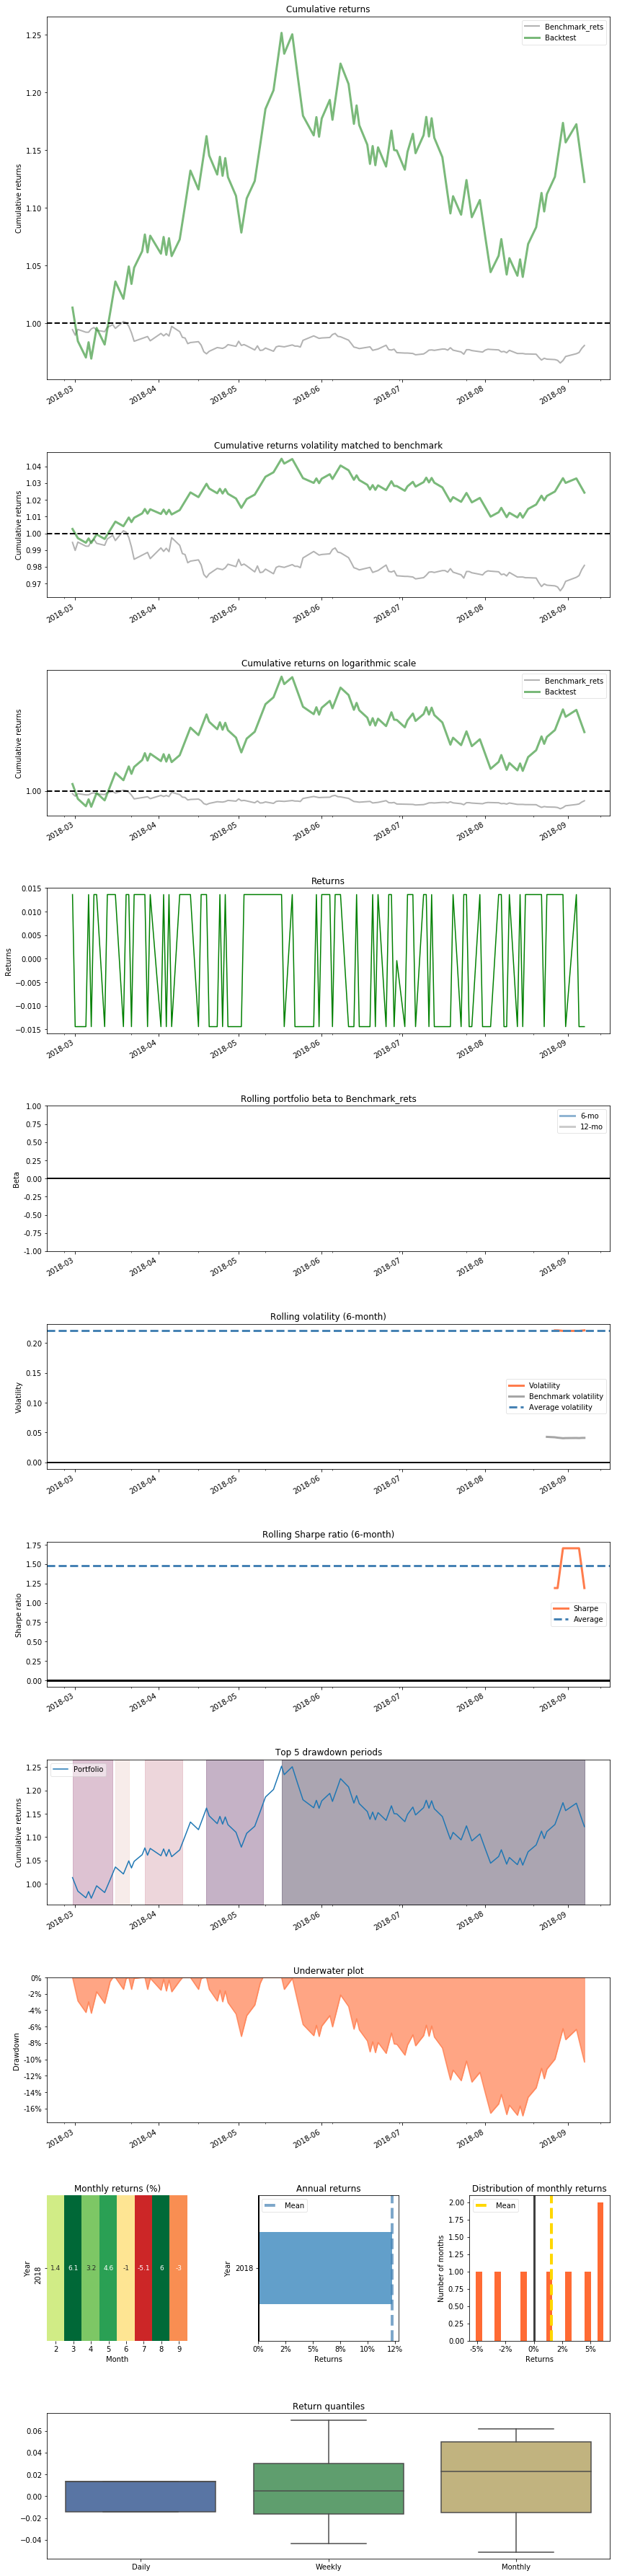

In [61]:
new_ret = (np.sign(pre_open_930_ret) *nine_thir_ret[1]) - 0.0004
create_custom_tear_sheet(returns=new_ret, benchmark_rets=df['Benchmark_rets'])

The results are pretty decent, but this strategy seems to be weaker compared to our original one. Let's put it a aside and go back to our original strategy!

## Back to our first strategy

## Using 0930-1000 trading volume as a filter

The academics mentioned that their strategy tends to work well during periods of elevated volume. In particular, they tested their strategy during periods of higher volume and found that the strategy worked better than expected. 

Therefore, we shall do the same and test it out using the trading volume of the opening half hour (0930 - 1000). 

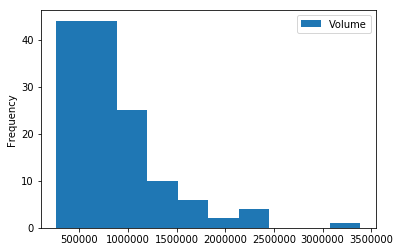

In [62]:
# Volume of the half hour trading from 09:30 to 10:00
vol_930 = data[data.index.time == datetime.time(9,30)]
vol_930.index = vol_930.index.normalize()
vol_930.plot.hist()

### Use a rolling window for our volume filter instead (to prevent lookahead bias)

Backtest months: 6


,Backtest
Annual return,8.3%
Cumulative returns,4.3%
Annual volatility,2.8%
Sharpe ratio,2.84
Calmar ratio,4.50
Stability,0.84
Max drawdown,-1.8%
Omega ratio,2.11
Sortino ratio,4.56
Skew,-0.39


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.84,2018-03-21,2018-04-03,2018-05-07,34
1,0.56,2018-06-14,2018-06-22,2018-08-07,39
2,0.52,2018-02-28,2018-03-01,2018-03-09,8
3,0.16,2018-05-22,2018-05-24,2018-05-25,4
4,0.05,2018-06-05,2018-06-06,2018-06-07,3


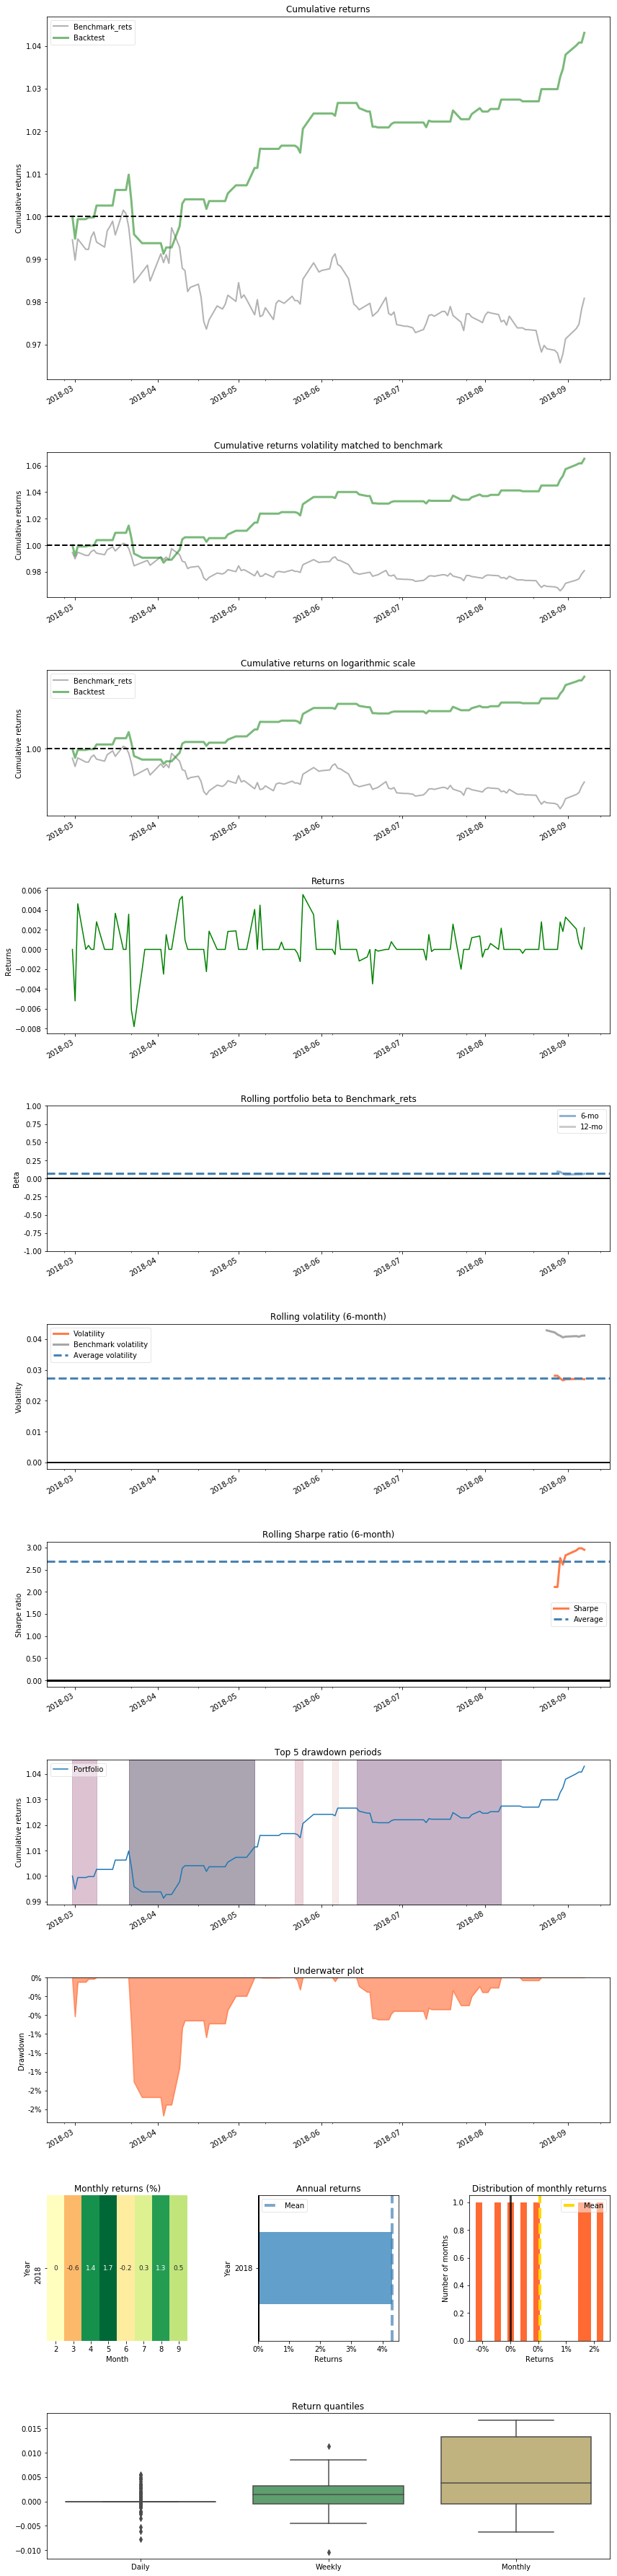

In [65]:
# Rolling average of the 5 day mean using the method of bfill for the initial 9 values (cheating a bit haha)
vol_930_roll_mean_5 = pd.rolling_mean(vol_930, 5).shift(1).fillna(method='bfill')
roll_5_comb_adj_ret = df['Strat_Daily_rets'] * (vol_930['Volume'] > vol_930_roll_mean_5['Volume'])
create_custom_tear_sheet(returns=roll_5_comb_adj_ret, benchmark_rets=df['Benchmark_rets'])

Adding a simple rolling 5 day volume filter seems to cause our performance to deteoriate. It seems like we are better sticking to a simple trading size volume. 

Overall, it seems like contrary to the academic results, we found a mean reverting effect between overnight returns and closing returns, instead of a momentum effect. Nonetheless, this trading strategy seems to be pretty robust though there is a big caveat mentioned. The capacity of this strategy seems to be fairly limited as it relies upon us entering the trade at 15:30pm and getting out of the closing auction. Therefore, the size in which we can reliably trade without impacting the market close remains up in the air. (probably a low capacity strategy)

Areas of further work that I can do. Investigate if there is any relationship between the overnight returns and pre-close returns, as well as performing sensitivity analysis on my strategy. For example, I could pertub the entry time and see if this strategy still works. Another way would be to use TAQ data to improve the accuracy of my backtest. Nonetheless, this has been an interesting experiment and I would love to try trading this strategy for real!